# IA317: Large-scale machine learning
# Tree search

In this lab, you will learn to work with [kd-trees](https://en.wikipedia.org/wiki/K-d_tree), in particular to build the graph of nearest neighbors.<br>
You will find below a function to build a kd-tree and to find the nearest neighbor of some target using this data structure.

## Instructions

Please provide short answers to the questions at the bottom of the notebook. Most involve Python coding. Add as many cells as necessary (code and text). You might test your code using synthetic data.

Before uploading your notebook on [eCampus](https://ecampus.paris-saclay.fr/course/view.php?id=18426), please:
* Delete all useless cells (tests, etc.)
* Check that **your code is running and does not produce any errors**. You might restart the kernel and run all cells at the end of the lab to check that this is indeed the case. 
* Keep the outputs.

The deadline is **Thursday, December 18th (midnight).**

## Import

In [1]:
import numpy as np

In [2]:
from scipy import sparse

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

In [5]:
import time

## Synthetic data

In [6]:
# Standard Gaussian model
X_synthetic = np.random.normal(size = (100,2))

## Real data

We will use a dataset providing the GPS coordinates of the ~13,000 largest cities of the world. For simplicity, we will use the Euclidean distance on the world map, with coordinates = (longitude, latitude).

In [7]:
#from google.colab import files
#uploaded = files.upload()

In [8]:
# First download the file
cities = pd.read_csv('worldcities.csv')

In [9]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795


In [10]:
names = list(cities['city'])
admin_names = list(cities['admin_name'])
lat = list(cities['lat'])
long = list(cities['lng'])

In [11]:
X = np.vstack((long,lat)).T

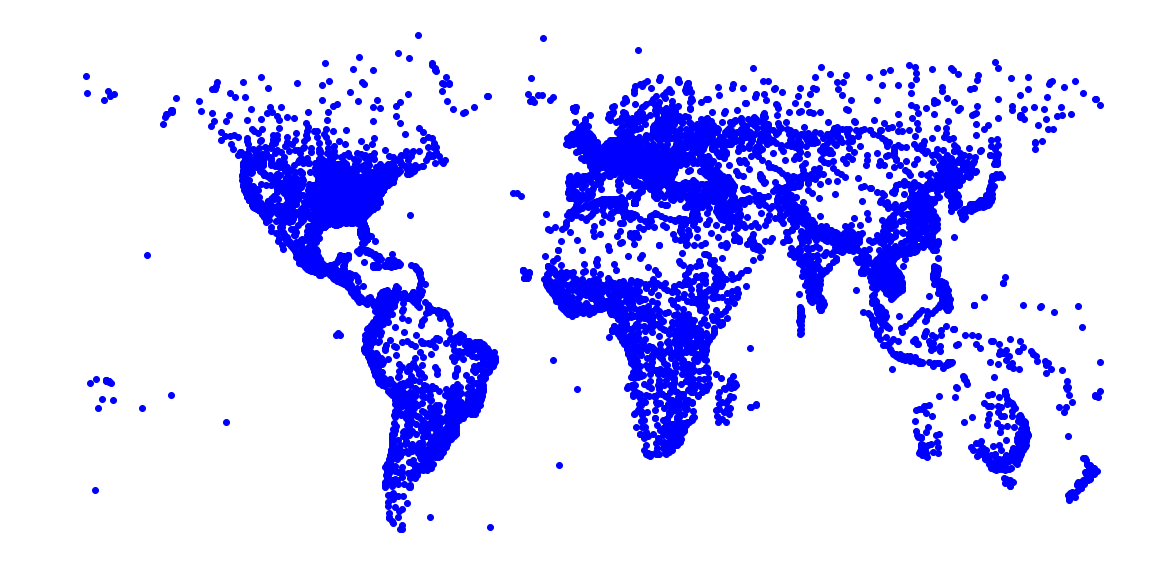

In [12]:
plt.figure(figsize = (20,10))
_ = plt.scatter(X[:,0], X[:,1], c='b')
_ = plt.axis('off')

## Kd trees

In [13]:
class KD_Tree:
    def __init__(self, index, ancestor, mins, maxs):
        self.index = index
        self.ancestor = ancestor
        self.mins = mins
        self.maxs = maxs
        self.direction = None        
        self.pivot = None
        self.left = None
        self.right = None

In [14]:
def split(X, index, method):
    '''Split method (max spread or max variance)
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray
        Sample indices, within range(n_samples)
    method : str, 'maxspread' or 'maxvariance'
        Method 
        
    Returns
    -------
    k : int
        Direction, in range(n_features)
    i : int
        Pivot, in range(n_samples)
    '''
    if method == 'maxspread':
        # max spread
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
        k = np.argmax(maxs - mins)
        middle = (maxs[k] + mins[k]) / 2
        i = index[np.argmin(np.abs(X[index,k] - middle))]
    else:
        # max variance
        k = np.argmax(np.std(X[index], axis = 0))
        i = index[np.argsort(X[index,k])[len(index) // 2]]
    return k, i

In [15]:
def build_kd_tree(X, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread'):
    '''Build the kd-tree from data.
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray or None
        Sample indices, within range(n_samples)
    ancestor : KD_Tree or None
        Ancestor of the current node
    mins : np.ndarray or None
        Min values of the rectangle, shape (n_features,)
    maxs : np.ndarray
        Max values of the rectangle, shape (n_features,)
    leaf_size : int
        Leaf size of the kd-tree 
    method : str, 'maxspread' or 'maxvariance'
        Split method 
        
    Returns
    -------
    tree : KD_Tree
        kd-tree
    '''
    if index is None:
        index = np.arange(X.shape[0])
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
    tree = KD_Tree(index, ancestor, mins, maxs)
    if len(index) > leaf_size:
        k,i = split(X, index, method)
        tree.direction, tree.pivot = k, i
        index = np.array(list(set(index) - {i}))
        index_left = index[np.where(X[index,k] <= X[i,k])[0]]
        maxs_ = maxs.copy()
        maxs_[k] = X[i,k]
        tree.left = build_kd_tree(X, index_left, tree, mins, maxs_, leaf_size, method)
        index_right = index[np.where(X[index,k] > X[i,k])[0]]
        mins_ = mins.copy()
        mins_[k] = X[i,k]        
        tree.right = build_kd_tree(X, index_right, tree, mins_, maxs, leaf_size, method)
    return tree

In [16]:
def search_leaf(x, X, tree):
    '''Search the leaf node of the kd-tree given some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    tree : KD_Tree
        Leaf node
    '''
    if tree.pivot is not None:
        k = tree.direction
        i = tree.pivot
        if x[k] <= X[i,k]:
            return search_leaf(x, X, tree.left)
        else:
            return search_leaf(x, X, tree.right)
    else:
        return tree

In [17]:
def nn_search_kd_tree(x, X, tree):
    '''Search the nearest neighbor of some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    nn : int
        Index of the nearest neighbor
    '''
    node = search_leaf(x, X, tree)
    index = node.index
    nn = None
    if len(index):
        nn = index[np.argmin(np.linalg.norm(X[index] - x, axis = 1))]
        dist = np.linalg.norm(X[nn] - x)
    
    while node.ancestor is not None:
        previous = node
        node = node.ancestor
        if nn is None or np.linalg.norm(X[node.pivot] - x) < dist:
            nn = node.pivot
            dist = np.linalg.norm(X[nn] - x)
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (np.linalg.norm(x - y) < dist)
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                nn_ = nn_search_kd_tree(x, X, tree_)
                dist_ = np.linalg.norm(X[nn_] - x)
                if dist_ < dist:
                    nn, dist = nn_, dist_
                tree_.ancestor = ancestor
    return nn

## Questions

1. What is the closest city from the [Null Island](https://fr.wikipedia.org/wiki/Null_Island) (provide the name)?

In [18]:
tree=build_kd_tree(X)
x=[0,0]
res=nn_search_kd_tree(x,X,tree)
print("The closest city from the Null Island is:",names[res])

The closest city from the Null Island is: Sekondi


2. What are the 10 closest cities from Paris (provide the names)?<br>
Choose the true Paris :-)

In [19]:
def search_kd_tree(x, X, tree,k):
    '''Search the nearest neighbor of some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    nn : int
        Index of the nearest neighbor
    '''
    node = search_leaf(x, X, tree)
    index = node.index
    res=[]
    while len(index)<k:
      if node.ancestor is None:
        return node.index
      else:
        node=node.ancestor
        index=node.index
    
    sort=np.argsort(np.linalg.norm(X[index] - x,axis=1))
    if (X[index[sort[0]]]==x).all():
      res=index[sort[1:k+1]]
    else:
      res=index[sort[0:k]]

    distances=np.linalg.norm(X[res] - x,axis=1)

    
    while node.ancestor is not None:
        previous = node
        node = node.ancestor
        if  np.linalg.norm(X[node.pivot] - x) < distances[-1]:
            #update
          res[-1]=node.pivot
          res=res[np.argsort(np.linalg.norm(X[res] - x,axis=1))]
          distances=np.linalg.norm(X[res] - x,axis=1)
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (np.linalg.norm(x - y) < distances[-1])
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                res_ = search_kd_tree(x, X, tree_ , k)
                distances_=np.linalg.norm(X[res_] - x,axis=1)
                #update distances
                if distances_[0]<distances[-1]:
                  res=np.hstack((res,res_))
                  res=res[np.argsort(np.linalg.norm(X[res] - x,axis=1))][0:k]
                  distances=distances=np.linalg.norm(X[res] - x,axis=1)
                tree_.ancestor = ancestor
    return res

In [20]:
k=10
node=names.index('Paris')
tree=build_kd_tree(X)
x=X[node]
res=search_kd_tree(x,X,tree,k)
neighbor=[]
for i in res:
  neighbor.append(names[i])
print("The 10 closest cities from Paris are:",neighbor)

The 10 closest cities from Paris are: ['Versailles', 'Melun', 'Amiens', 'Orléans', 'Rouen', 'Arras', 'Auxerre', 'Dieppe', 'Reims', 'Bourges']


3. Compare the previous search time to a brute force approach (with default leaf size = 30).

In [21]:
start = time.time()

k=10
node=names.index('Paris')
tree=build_kd_tree(X)
x=X[node]
res=search_kd_tree(x,X,tree,k)

end = time.time()

print ("The running time for the previous search is :",str(end-start))

The running time for the previous search is : 0.14840435981750488


Then we write a function using the brute force approach to calculate the running time.

In [22]:
start = time.time()

# node=names.index('Paris')
# tree=build_kd_tree(X)
# index=tree.index
# res=index[np.argsort(np.linalg.norm(X[index]-X[node],axis=1))][1:11]
# neighbor=[]
# for i in res:
#   neighbor.append(names[i])
# print("The 10 closest cities from Paris are:",neighbor)

node=names.index('Paris')
x=X[node]
k=10
res=np.ones(k)
dis=np.ones(k)*len(X)
for i in range(len(X)):
  t=np.linalg.norm(X[i]-x)
  if t!=0 and t<dis[-1]:
    dis[-1]=t
    res[-1]=int(i)
    res=res[np.argsort(dis)]
    dis=np.sort(dis)
neighbor=[]
for i in res:
  neighbor.append(names[int(i)])
print("The 10 closest cities from Paris are:",neighbor)

end = time.time()

print ("The running time for the brute force approach is :",str(end-start))

The 10 closest cities from Paris are: ['Versailles', 'Melun', 'Amiens', 'Orléans', 'Rouen', 'Arras', 'Auxerre', 'Dieppe', 'Reims', 'Bourges']
The running time for the brute force approach is : 0.21088647842407227


We find that in this case the running time is similar for these two methods. But the kd tree method run faster.

4. Do the same comparison for synthetic data (with $10^6$ samples for instance). Comment.

In [23]:
X_synthetic = np.random.normal(size = (int(1e6),2))

start = time.time()

k=10
node=np.random.randint(0,int(1e6))
tree=build_kd_tree(X_synthetic)
x=X_synthetic[node]
res=search_kd_tree(x,X_synthetic,tree,k)

end = time.time()

print ("The running time for the previous search is :",str(end-start))

The running time for the previous search is : 16.649375915527344


In [24]:
start = time.time()

node=np.random.randint(0,int(1e6))
tree=build_kd_tree(X_synthetic)
index=tree.index
res=index[np.argsort(np.linalg.norm(X_synthetic[index]-X_synthetic[node],axis=1))][1:k+1]

end = time.time()
print ("The running time for the brute force approach is :",str(end-start))

# X_synthetic = np.random.normal(size = (int(1e6),2))
# node=np.random.randint(0,int(1e6))
# x=X_synthetic[node]
# k=10
# res=np.ones(k)
# dis=np.ones(k)*len(X_synthetic)
# for i in range(len(X_synthetic)):
#   t=np.linalg.norm(X_synthetic[i]-x)
#   if t!=0 and t<dis[-1]:
#     dis[-1]=t
#     res[-1]=int(i)
#     res=res[np.argsort(dis)]
#     dis=np.sort(dis)

# end = time.time()

# print ("The running time for the brute force approach is :",str(end-start))

The running time for the brute force approach is : 16.489493370056152


It seems the kd tree method is faster.

5. What is the depth of the leaf node containing Paris in the kd-tree? <br>
Test various leaf sizes (e.g., 1, 10, 100, ...) and comment.

In [25]:
node=names.index('Paris')
tree=build_kd_tree(X,leaf_size=1)
node=search_leaf(x, X, tree)
depth=0
while node.ancestor is not None:
  node=node.ancestor
  depth+=1
print("When the leaf size is 1,the depth is :",depth)

When the leaf size is 1,the depth is : 12


In [26]:
node=names.index('Paris')
tree=build_kd_tree(X,leaf_size=10)
node=search_leaf(x, X, tree)
depth=0
while node.ancestor is not None:
  node=node.ancestor
  depth+=1
print("When the leaf size is 10,the depth is :",depth)

When the leaf size is 10,the depth is : 10


In [27]:
node=names.index('Paris')
tree=build_kd_tree(X,leaf_size=100)
node=search_leaf(x, X, tree)
depth=0
while node.ancestor is not None:
  node=node.ancestor
  depth+=1
print("When the leaf size is 100,the depth is :",depth)

When the leaf size is 100,the depth is : 8


6. Build the graph of 3-nearest neighbors. You must return the adjacency matrix of the graph in the sparse format of your choice. How many connected components are there in this graph, considered as undirected (check [this](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.connected_components.html))? Show the 3 largest connected components on the map. 

In [28]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

n=len(X)
graph = csr_matrix((n, n))
k=3
tree=build_kd_tree(X)
for i in range(n):
  neighbor=search_kd_tree(X[i],X,tree,k)
  for j in neighbor:
    graph[i,j]=1
    graph[j,i]=1
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)

F:\AI\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  # This is added back by InteractiveShellApp.init_path()
F:\AI\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  if sys.path[0] == '':


In [29]:
from collections import Counter
print("The  the 3 largest connected components are:",Counter(labels).most_common(3))

The  the 3 largest connected components are: [(0, 5326), (9, 4473), (17, 1024)]


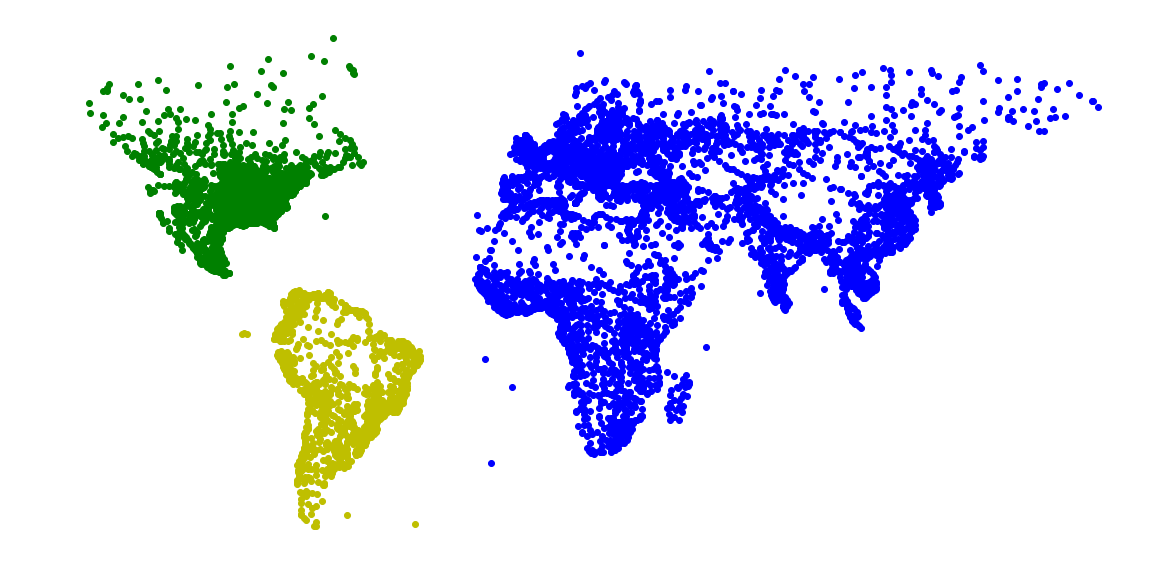

In [30]:
plt.figure(figsize = (20,10))
part=[0,9,17]
for i in range(n):
  if labels[i] in part:
    if labels[i]==0:
      plt.scatter(X[i,0], X[i,1], c='b')
    if labels[i]==9:
      plt.scatter(X[i,0], X[i,1], c='g')
    if labels[i]==17:
      plt.scatter(X[i,0], X[i,1], c='y')  
_ = plt.axis('off')   

7. (optional) Code the nearest neighbor search with a ball tree and compare the performance with kd-trees.

8. (optional) Do the same with the actual distances between cities!